In [1]:
import numpy as np
from skimage.draw import polygon2mask
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import math
from typing import Tuple
import json
import os
import os.path as osp
import glob
import nibabel as nib
import numpy as np
from matplotlib import pyplot as plt
import skimage.transform as ST
from pydicom import dcmread
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from scipy import ndimage
from pydicom.pixel_data_handlers.util import apply_modality_lut
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import nibabel as nib
from ipywidgets import interact
import shutil

from pydicom.encaps import encapsulate


In [2]:
def windowing(data_hu, w_min, w_max, min_value, max_value):
    data_hu = ((data_hu - w_min) / (w_max - w_min)
               * (max_value - min_value)) + min_value
    data_hu = np.where(data_hu < min_value, min_value, data_hu)
    data_hu = np.where(data_hu > max_value, max_value, data_hu)
    return data_hu


def DICE_COE(mask1, mask2):
    intersect = np.sum(mask1*mask2)
    fsum = np.sum(mask1)
    ssum = np.sum(mask2)
    dice = (2 * intersect) / (fsum + ssum)
    dice = np.mean(dice)
    return dice


def IOU_score(result1, result2):
    intersection = np.logical_and(result1, result2)
    union = np.logical_or(result1, result2)
    if np.sum(union) == 0:
        iou_score = 0
    else:
        iou_score = np.sum(intersection) / np.sum(union)
    return iou_score


def read_dcm_series(dcm_files, select_series, slice_thickness):
    ds_dcm_files = []
    series_desc = []

    for fp in dcm_files:
        ds = dcmread(fp)
        ds.PhotometricInterpretation = 'YBR_FULL'
        series_desc.append(ds.SeriesDescription)
        if select_series.lower() in ds.SeriesDescription.lower() \
           and slice_thickness == float(ds.SliceThickness):
            ds_dcm_files.append(ds)
    series_desc = np.unique(series_desc)
    print(series_desc)

    print(os.path.dirname(dcm_files[0]))
    if (len(ds_dcm_files)) == 0:
        print(f'  Does not have: {select_series}')
        print(f'  Only have: {series_desc}')
        return

    print(f'ImageOrientation: {ds_dcm_files[0].ImageOrientationPatient}')

    # skip files with no SliceLocation (eg scout views)
    slices = []
    skipcount = 0
    for f in ds_dcm_files:
        if hasattr(f, 'SliceLocation'):
            slices.append(f)
        else:
            skipcount = skipcount + 1

    print("skipped, no SliceLocation: {}".format(skipcount))

    # ensure they are in the correct order
    slices = sorted(slices, key=lambda s: s.SliceLocation)

    # create 3D array
    img_shape = list(slices[0].pixel_array.shape)
    img_shape.append(len(slices))
    img3d = np.zeros(img_shape)

    # fill 3D array with the images from the files
    for i, s in enumerate(slices):
        img2d = apply_modality_lut(s.pixel_array, s)
        img3d[:, :, i] = img2d
    print(f'3D Array: {img3d.shape}')

    return img3d


# Visualize and compare to doctor annotations

In [3]:
def correct_orientation_mask(csf_mask, mod):
    if mod == 'spm12':
        csf_mask = np.rot90(csf_mask, axes=(0, 1))
    elif mod == 'ct2d':
        csf_mask = np.rot90(csf_mask, axes=(0, 1))
    elif mod == 'ct3d':
        csf_mask = np.rot90(csf_mask, axes=(0, 1))
    elif mod == 'weak':
        csf_mask = np.rot90(csf_mask, axes=(0, 1))
    elif mod == 'doctor':
        csf_mask = np.rot90(csf_mask, axes=(1, 0))
        csf_mask = np.fliplr(csf_mask)
    return csf_mask


def generate_img_mask(x_rgb, csf_mask, mod, with_noncsf=True):
    csf_mask = correct_orientation_mask(csf_mask, mod)
    overlay_x = np.copy(x_rgb)
    overlay_x[(csf_mask == 1)] = [255, 0, 0]
    if with_noncsf:
        overlay_x[(csf_mask == 2)] = [0, 0, 255]
    overlay_x_w = cv2.addWeighted(overlay_x, 0.5, x_rgb, 0.5, 0, overlay_x)
    return overlay_x_w


In [4]:
'''
new file change path of spm12 to segmentation_mask_v3 for show csf anf non-csf
annotate_df is df of detail and location's file of each patient
'''
annotate_df = pd.read_csv('./annotate-segv3.csv')
annotate_df['json'] = annotate_df['name']+'.json'
annotate_df


,no,HN,name,slice index,complete,class,slice index.1,test_fold,weak,spm12,dcm,headCT,nph,json
0,2.0,44119324,sample_normal_44119324,49 8355,True,0,84.0,1,/data2-2tb/kgreathoo/saved_img/nii_42_focallos...,/data4-4tb/kgreathoo/dataset_norm_mask_by_revi...,/data4-4tb/kgreathoo/dcm_dataset/Non-NPH/44119324,/data4-4tb/kgreathoo/HeadCTSegmentation/result...,/data4-4tb/kgreathoo/NPH_Prediction/UNet_Outpu...,sample_normal_44119324.json
1,3.0,46152726,sample_normal_46152726_non,60.57,True,0,72.0,0,/data2-2tb/kgreathoo/saved_img/nii_42_focallos...,/data4-4tb/kgreathoo/dataset_norm_mask_by_revi...,/data4-4tb/kgreathoo/dcm_dataset/Non-NPH/46152726,/data4-4tb/kgreathoo/HeadCTSegmentation/result...,/data4-4tb/kgreathoo/NPH_Prediction/UNet_Outpu...,sample_normal_46152726_non.json
2,4.0,50186221,sample_normal_50186221_non contrast 1.25 mm_,50.9945,True,0,83.0,0,/data2-2tb/kgreathoo/saved_img/nii_42_focallos...,/data4-4tb/kgreathoo/dataset_norm_mask_by_revi...,/data4-4tb/kgreathoo/dcm_dataset/Non-NPH/50186221,/data4-4tb/kgreathoo/HeadCTSegmentation/result...,/data4-4tb/kgreathoo/NPH_Prediction/UNet_Outpu...,sample_normal_50186221_non contrast 1.25 mm_.json
3,5.0,51131969,sample_normal_51131969,52.4535,True,0,75.0,4,/data2-2tb/kgreathoo/saved_img/nii_42_focallos...,/data4-4tb/kgreathoo/dataset_norm_mask_by_revi...,/data4-4tb/kgreathoo/dcm_dataset/Non-NPH/51131969,/data4-4tb/kgreathoo/HeadCTSegmentation/result...,/data4-4tb/kgreathoo/NPH_Prediction/UNet_Outpu...,sample_normal_51131969.json
4,8.0,53798105,sample_normal_53798105,53.7021,True,0,71.0,4,/data2-2tb/kgreathoo/saved_img/nii_42_focallos...,/data4-4tb/kgreathoo/dataset_norm_mask_by_revi...,/data4-4tb/kgreathoo/dcm_dataset/Non-NPH/53798105,/data4-4tb/kgreathoo/HeadCTSegmentation/result...,/data4-4tb/kgreathoo/NPH_Prediction/UNet_Outpu...,sample_normal_53798105.json
5,15.0,50296397,sample_NPH_50296397,62.417,True,1,73.0,-,/data2-2tb/kgreathoo/saved_img/nii_42_focallos...,/data4-4tb/kgreathoo/dataset_norm_mask_by_revi...,/data4-4tb/kgreathoo/nph_dec_dcm/NPH4/50296397...,/data4-4tb/kgreathoo/HeadCTSegmentation/result...,/data4-4tb/kgreathoo/NPH_Prediction/UNet_Outpu...,sample_NPH_50296397.json
6,18.0,53701955,sample_NPH_53701955,63.632,True,1,58.0,-,/data2-2tb/kgreathoo/saved_img/nii_42_focallos...,/data4-4tb/kgreathoo/dataset_norm_mask_by_revi...,/data4-4tb/kgreathoo/nph_dec_dcm/NPH 2/5370195...,/data4-4tb/kgreathoo/HeadCTSegmentation/result...,/data4-4tb/kgreathoo/NPH_Prediction/UNet_Outpu...,sample_NPH_53701955.json
7,21.0,38000954,sample_NPH_38000954,NaN,True,1,NaN,0,/data2-2tb/kgreathoo/saved_img/nii_42_focallos...,/data4-4tb/kgreathoo/dataset_norm_mask_by_revi...,/data4-4tb/kgreathoo/dcm_dataset/NPH/38000954/,/data4-4tb/kgreathoo/HeadCTSegmentation/result...,/data4-4tb/kgreathoo/NPH_Prediction/UNet_Outpu...,sample_NPH_38000954.json
8,NaN,53021653,FP,NaN,True,0,NaN,2,/data2-2tb/kgreathoo/saved_img/nii_42_focallos...,/data4-4tb/kgreathoo/dataset_norm_mask_by_revi...,/data4-4tb/kgreathoo/dcm_dataset/Non-NPH/53021653,/data4-4tb/kgreathoo/HeadCTSegmentation/result...,/data4-4tb/kgreathoo/NPH_Prediction/UNet_Outpu...,FP.json
9,NaN,52531308,FP,NaN,True,0,NaN,4,/data2-2tb/kgreathoo/saved_img/nii_42_focallos...,/data4-4tb/kgreathoo/dataset_norm_mask_by_revi...,/data4-4tb/kgreathoo/dcm_dataset/Non-NPH/52531308,/data4-4tb/kgreathoo/HeadCTSegmentation/result...,/data4-4tb/kgreathoo/NPH_Prediction/UNet_Outpu...,FP.json


In [5]:
nonnph_HNs = annotate_df[annotate_df['class'] == 0]['HN'].values
nph_HNs = annotate_df[annotate_df['class'] == 1]['HN'].values
print(f'Non-NPH: {nonnph_HNs}')
print(f'NPH: {nph_HNs}')


Non-NPH: [44119324 46152726 50186221 51131969 53798105 53021653 52531308 38004023]
NPH: [50296397 53701955 38000954]


In [6]:
# Subject to display with the criteria for series selection
c_ann_map = {
    #     0: '1.25', #not use because worse
    1: 'non',
    2: 'non',
    3: 'non',
    4: 'non',
    5: 'non',
    6: 'non',
}


In [7]:
# Generate masks in nifti and jpeg format
for k, v in c_ann_map.items():
    current_p = annotate_df.iloc[k]
    hn = current_p['HN']
    dcm_dir = current_p['dcm']
    weak_mask_fp = current_p['weak']
    spm12_mask_fp = current_p['spm12']
    ct2D_mask_fp = current_p['headCT']
    ct3D_mask_fp = current_p['nph']
    doctor_ann_json = current_p['json']
    with open(doctor_ann_json, 'r') as _f:
        data = json.load(_f)
    doctor_ann = data['data_evaluation']

    '''
    in below replace folder's name by version of mask or replace folder's name by version of model
    '''
    # Replace with new SPM12 version
    spm12_mask_fp = spm12_mask_fp.replace(
        'segmentation_mask_v3',
        'segment_mask_confidence1_contour')

#     # Replace with new weak with 1 confident
#     weak_mask_fp = weak_mask_fp.replace(
#     'nii_42_focalloss_200epochs_lr_init=0.001_unet_scaled_(0,40)(0,20)(20,40)_224_allSlice_byTime_fold',
#     '/nii/SPM12floatCodeConfident1_focalloss_200epochs_lr_init=0.001_unet_scaled_(0,40)(0,20)(20,40)_224_allSlice_byTime_fold')

    dcm_files = list(glob.glob(os.path.join(dcm_dir, '*')))
    series = v

    # add dcm data to image variable
    image = read_dcm_series(dcm_files,
                            select_series=series,
                            slice_thickness=1.25)
    x_hu = image
    x = windowing(x_hu, w_min=-5, w_max=60, min_value=0, max_value=1)

    # SPM12
    spm12_mask = nib.load(spm12_mask_fp).get_fdata()
    spm12_mask = cv2.resize(spm12_mask.astype('uint8'), dsize=(224, 224))

    # 2D Unet
    ct2d_mask = nib.load(ct2D_mask_fp).get_fdata()
    ct2d_mask = np.where(ct2d_mask == 0, 0, np.where(
        np.logical_or(ct2d_mask == 2, ct2d_mask == 10), 1, 2))
    ct2d_mask = cv2.resize(ct2d_mask.astype('uint8'), dsize=(224, 224))

    # 3D Unet
    ct3d_mask = nib.load(ct3D_mask_fp).get_fdata()
    ct3d_mask = np.where(ct3d_mask == 2, 2, np.where(
        np.logical_or(ct3d_mask == 1, ct3d_mask == 3), 1, 0))  # add non-csf
    ct3d_mask = cv2.resize(ct3d_mask.astype('uint8'), dsize=(224, 224))

    # Our
    weak_mask = nib.load(weak_mask_fp).get_fdata()
    weak_mask = weak_mask.astype('uint8')

    print(spm12_mask.shape, np.unique(spm12_mask))
    print(ct2d_mask.shape, np.unique(ct2d_mask))
    print(ct3d_mask.shape, np.unique(ct3d_mask))
    print(weak_mask.shape, np.unique(weak_mask))

    # Save nifti
    out_dir = f'./temp_test/{hn}'
    if os.path.exists(out_dir) and os.path.isdir(out_dir):
        shutil.rmtree(out_dir)
    os.makedirs(out_dir)
    save_mask = nib.Nifti1Image(spm12_mask.astype(np.int8), affine=np.eye(4))
    nib.save(save_mask, os.path.join(out_dir, 'spm12_mask.nii'))

    save_mask = nib.Nifti1Image(ct2d_mask.astype(np.int8), affine=np.eye(4))
    nib.save(save_mask, os.path.join(out_dir, 'ct2d_mask.nii'))

    save_mask = nib.Nifti1Image(ct3d_mask.astype(np.int8), affine=np.eye(4))
    nib.save(save_mask, os.path.join(out_dir, 'ct3d_mask.nii'))

    save_mask = nib.Nifti1Image(weak_mask.astype(np.int8), affine=np.eye(4))
    nib.save(save_mask, os.path.join(out_dir, 'weak_mask.nii'))

    # Image
    out_img_dir = f'{out_dir}/image_masks'
    os.makedirs(out_img_dir)
    for slice_idx in range((x.shape[-1])):
        x_gray = x[:, :, slice_idx]*255
        x_gray = cv2.resize(x_gray.astype('uint8'), dsize=(224, 224))
        x_rgb = cv2.cvtColor(x_gray, cv2.COLOR_GRAY2RGB)

        # CSF overlay
        spm12_img = generate_img_mask(
            x_rgb, spm12_mask[:, :, slice_idx], mod='spm12')
        ct2d_img = generate_img_mask(
            x_rgb, ct2d_mask[:, :, slice_idx], mod='ct2d')
        ct3d_img = generate_img_mask(
            x_rgb, ct3d_mask[:, :, slice_idx], mod='ct3d')
        weak_img = generate_img_mask(
            x_rgb, weak_mask[:, :, slice_idx], mod='weak')

        # Plot
        fig, axs = plt.subplots(3, 2, figsize=(12, 16))
        fig.subplots_adjust(wspace=0, hspace=0)
        axs[0, 0].imshow(x_rgb)
        axs[0, 0].axis('off')
#         axs[0,0].text(10, 10, 'DATA', color='white', fontsize=28, ha='left', va='top')
        axs[1, 0].imshow(spm12_img)
        axs[1, 0].text(5, 5, 'SPM', color='white',
                       fontsize=24, ha='left', va='top')
        axs[1, 0].axis('off')
        axs[1, 1].imshow(weak_img)
        axs[1, 1].text(5, 5, 'WEAK', color='white',
                       fontsize=24, ha='left', va='top')
        axs[1, 1].axis('off')
        axs[2, 0].imshow(ct2d_img)
        axs[2, 0].text(5, 5, 'CT2D', color='white',
                       fontsize=24, ha='left', va='top')
        axs[2, 0].axis('off')
        axs[2, 1].imshow(ct3d_img)
        axs[2, 1].text(5, 5, 'CT3D', color='white',
                       fontsize=24, ha='left', va='top')
        axs[2, 1].axis('off')

        shift_dis_x = 10
        shift_dis_y = 0
        image_shape = (512, 512)
        suffix = ''
        if doctor_ann[f'{slice_idx+1}'].get('additional'):
            doc_ann_mask = np.zeros(image_shape)
            for k in doctor_ann[f'{slice_idx+1}']['additional'].keys():
                for r in doctor_ann[f'{slice_idx+1}']['additional'][k]['FreehandRoi']['data']:
                    points = r['handles']['points']
                    list_point = []
                    for point in points:
                        list_point.append(
                            [point['x']-shift_dis_x, point['y']-shift_dis_y])
                    polygon = np.array(list_point)
                    mask = polygon2mask(image_shape, polygon)
                    doc_ann_mask += mask
            doc_ann_mask = np.where(doc_ann_mask > 1, 1, doc_ann_mask)
            doc_ann_mask = cv2.resize(
                doc_ann_mask.astype('uint8'), dsize=(224, 224))
            doc_img = generate_img_mask(x_rgb, doc_ann_mask, mod='doctor')
            axs[0, 1].imshow(doc_img)
            axs[0, 1].text(5, 5, 'RAD', color='white',
                           fontsize=24, ha='left', va='top')
            suffix = '_ann'
        axs[0, 1].axis('off')

        plt.tight_layout()
        save_img_path = os.path.join(
            out_img_dir, f'mask{slice_idx}{suffix}.jpg')
        plt.savefig(save_img_path)
        print(f'Saved: {save_img_path}')
        plt.close('all')


['Non Contrast 1.25 mm']
/data4-4tb/kgreathoo/dcm_dataset/Non-NPH/46152726
ImageOrientation: [1.000000, 0.000000, 0.000000, 0.000000, 1.000000, 0.000000]
skipped, no SliceLocation: 0
3D Array: (512, 512, 137)
(224, 224, 137) [0 1 2]
(224, 224, 137) [0 1 2]
(224, 224, 137) [0 1 2]
(224, 224, 137) [0 1 2]
Saved: ./temp_test/46152726/image_masks/mask0.jpg
Saved: ./temp_test/46152726/image_masks/mask1.jpg
Saved: ./temp_test/46152726/image_masks/mask2.jpg
Saved: ./temp_test/46152726/image_masks/mask3.jpg
Saved: ./temp_test/46152726/image_masks/mask4.jpg
Saved: ./temp_test/46152726/image_masks/mask5.jpg
Saved: ./temp_test/46152726/image_masks/mask6.jpg
Saved: ./temp_test/46152726/image_masks/mask7.jpg
Saved: ./temp_test/46152726/image_masks/mask8.jpg
Saved: ./temp_test/46152726/image_masks/mask9.jpg
Saved: ./temp_test/46152726/image_masks/mask10.jpg
Saved: ./temp_test/46152726/image_masks/mask11.jpg
Saved: ./temp_test/46152726/image_masks/mask12.jpg
Saved: ./temp_test/46152726/image_masks/ma

Saved: ./temp_test/50186221/image_masks/mask12.jpg
Saved: ./temp_test/50186221/image_masks/mask13.jpg
Saved: ./temp_test/50186221/image_masks/mask14.jpg
Saved: ./temp_test/50186221/image_masks/mask15.jpg
Saved: ./temp_test/50186221/image_masks/mask16.jpg
Saved: ./temp_test/50186221/image_masks/mask17.jpg
Saved: ./temp_test/50186221/image_masks/mask18.jpg
Saved: ./temp_test/50186221/image_masks/mask19.jpg
Saved: ./temp_test/50186221/image_masks/mask20.jpg
Saved: ./temp_test/50186221/image_masks/mask21.jpg
Saved: ./temp_test/50186221/image_masks/mask22.jpg
Saved: ./temp_test/50186221/image_masks/mask23.jpg
Saved: ./temp_test/50186221/image_masks/mask24.jpg
Saved: ./temp_test/50186221/image_masks/mask25.jpg
Saved: ./temp_test/50186221/image_masks/mask26.jpg
Saved: ./temp_test/50186221/image_masks/mask27.jpg
Saved: ./temp_test/50186221/image_masks/mask28.jpg
Saved: ./temp_test/50186221/image_masks/mask29.jpg
Saved: ./temp_test/50186221/image_masks/mask30.jpg
Saved: ./temp_test/50186221/ima

Saved: ./temp_test/51131969/image_masks/mask30.jpg
Saved: ./temp_test/51131969/image_masks/mask31.jpg
Saved: ./temp_test/51131969/image_masks/mask32.jpg
Saved: ./temp_test/51131969/image_masks/mask33.jpg
Saved: ./temp_test/51131969/image_masks/mask34.jpg
Saved: ./temp_test/51131969/image_masks/mask35.jpg
Saved: ./temp_test/51131969/image_masks/mask36.jpg
Saved: ./temp_test/51131969/image_masks/mask37.jpg
Saved: ./temp_test/51131969/image_masks/mask38.jpg
Saved: ./temp_test/51131969/image_masks/mask39.jpg
Saved: ./temp_test/51131969/image_masks/mask40.jpg
Saved: ./temp_test/51131969/image_masks/mask41.jpg
Saved: ./temp_test/51131969/image_masks/mask42.jpg
Saved: ./temp_test/51131969/image_masks/mask43.jpg
Saved: ./temp_test/51131969/image_masks/mask44.jpg
Saved: ./temp_test/51131969/image_masks/mask45.jpg
Saved: ./temp_test/51131969/image_masks/mask46.jpg
Saved: ./temp_test/51131969/image_masks/mask47.jpg
Saved: ./temp_test/51131969/image_masks/mask48.jpg
Saved: ./temp_test/51131969/ima

Saved: ./temp_test/53798105/image_masks/mask52.jpg
Saved: ./temp_test/53798105/image_masks/mask53.jpg
Saved: ./temp_test/53798105/image_masks/mask54.jpg
Saved: ./temp_test/53798105/image_masks/mask55.jpg
Saved: ./temp_test/53798105/image_masks/mask56.jpg
Saved: ./temp_test/53798105/image_masks/mask57.jpg
Saved: ./temp_test/53798105/image_masks/mask58.jpg
Saved: ./temp_test/53798105/image_masks/mask59.jpg
Saved: ./temp_test/53798105/image_masks/mask60.jpg
Saved: ./temp_test/53798105/image_masks/mask61.jpg
Saved: ./temp_test/53798105/image_masks/mask62.jpg
Saved: ./temp_test/53798105/image_masks/mask63.jpg
Saved: ./temp_test/53798105/image_masks/mask64.jpg
Saved: ./temp_test/53798105/image_masks/mask65.jpg
Saved: ./temp_test/53798105/image_masks/mask66.jpg
Saved: ./temp_test/53798105/image_masks/mask67.jpg
Saved: ./temp_test/53798105/image_masks/mask68.jpg
Saved: ./temp_test/53798105/image_masks/mask69.jpg
Saved: ./temp_test/53798105/image_masks/mask70_ann.jpg
Saved: ./temp_test/53798105

Saved: ./temp_test/50296397/image_masks/mask79.jpg
Saved: ./temp_test/50296397/image_masks/mask80.jpg
Saved: ./temp_test/50296397/image_masks/mask81.jpg
Saved: ./temp_test/50296397/image_masks/mask82.jpg
Saved: ./temp_test/50296397/image_masks/mask83.jpg
Saved: ./temp_test/50296397/image_masks/mask84.jpg
Saved: ./temp_test/50296397/image_masks/mask85.jpg
Saved: ./temp_test/50296397/image_masks/mask86.jpg
Saved: ./temp_test/50296397/image_masks/mask87.jpg
Saved: ./temp_test/50296397/image_masks/mask88.jpg
Saved: ./temp_test/50296397/image_masks/mask89.jpg
Saved: ./temp_test/50296397/image_masks/mask90.jpg
Saved: ./temp_test/50296397/image_masks/mask91.jpg
Saved: ./temp_test/50296397/image_masks/mask92.jpg
Saved: ./temp_test/50296397/image_masks/mask93.jpg
Saved: ./temp_test/50296397/image_masks/mask94.jpg
Saved: ./temp_test/50296397/image_masks/mask95.jpg
Saved: ./temp_test/50296397/image_masks/mask96.jpg
Saved: ./temp_test/50296397/image_masks/mask97.jpg
Saved: ./temp_test/50296397/ima

Saved: ./temp_test/53701955/image_masks/mask105.jpg
Saved: ./temp_test/53701955/image_masks/mask106.jpg
Saved: ./temp_test/53701955/image_masks/mask107.jpg
Saved: ./temp_test/53701955/image_masks/mask108.jpg
Saved: ./temp_test/53701955/image_masks/mask109.jpg
Saved: ./temp_test/53701955/image_masks/mask110.jpg
Saved: ./temp_test/53701955/image_masks/mask111.jpg


# Calculate DICE and IoU Scores

['Non Contrast 1.25 mm']
/data4-4tb/kgreathoo/dcm_dataset/Non-NPH/46152726
ImageOrientation: [1.000000, 0.000000, 0.000000, 0.000000, 1.000000, 0.000000]
skipped, no SliceLocation: 0
3D Array: (512, 512, 137)
46152726
SPM12: dice=0.6547 iou=0.4867
CT2D: dice=0.7145 iou=0.5558
CT3D: dice=0.5517 iou=0.3810
WEAK: dice=0.6313 iou=0.4613


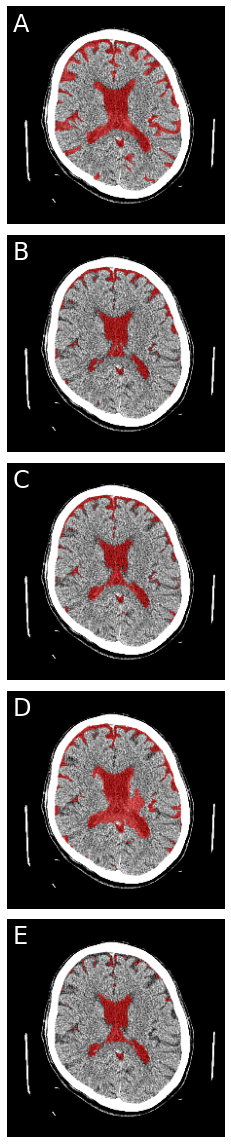

['Non Contrast 1.25 mm']
/data4-4tb/kgreathoo/dcm_dataset/Non-NPH/50186221
ImageOrientation: [1.000000, 0.000000, 0.000000, 0.000000, 1.000000, 0.000000]
skipped, no SliceLocation: 0
3D Array: (512, 512, 137)
50186221
SPM12: dice=0.5115 iou=0.3436
CT2D: dice=0.7336 iou=0.5793
CT3D: dice=0.4099 iou=0.2577
WEAK: dice=0.6243 iou=0.4538


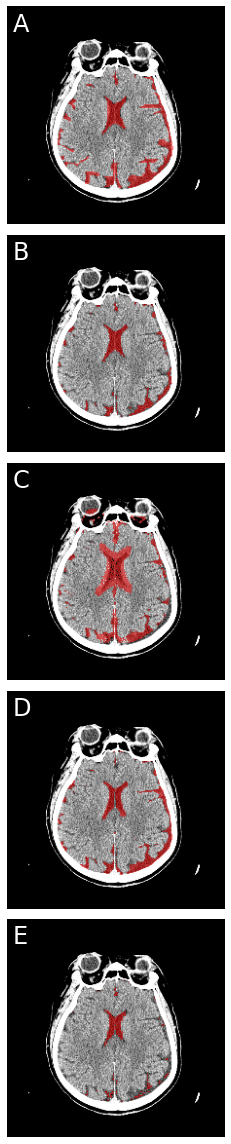

['Non Contrast 1.25 mm']
/data4-4tb/kgreathoo/dcm_dataset/Non-NPH/51131969
ImageOrientation: [1.000000, 0.000000, 0.000000, 0.000000, 1.000000, 0.000000]
skipped, no SliceLocation: 0
3D Array: (512, 512, 133)
51131969
SPM12: dice=0.7443 iou=0.5928
CT2D: dice=0.8087 iou=0.6788
CT3D: dice=0.7659 iou=0.6206
WEAK: dice=0.7919 iou=0.6554


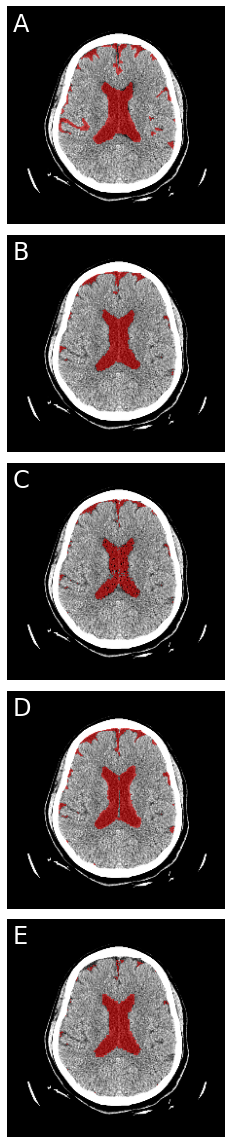

['Non Contrast 1.25 mm']
/data4-4tb/kgreathoo/dcm_dataset/Non-NPH/53798105
ImageOrientation: [1.000000, 0.000000, 0.000000, 0.000000, 1.000000, 0.000000]
skipped, no SliceLocation: 0
3D Array: (512, 512, 128)
53798105
SPM12: dice=0.7155 iou=0.5571
CT2D: dice=0.7915 iou=0.6550
CT3D: dice=0.6502 iou=0.4817
WEAK: dice=0.7335 iou=0.5792


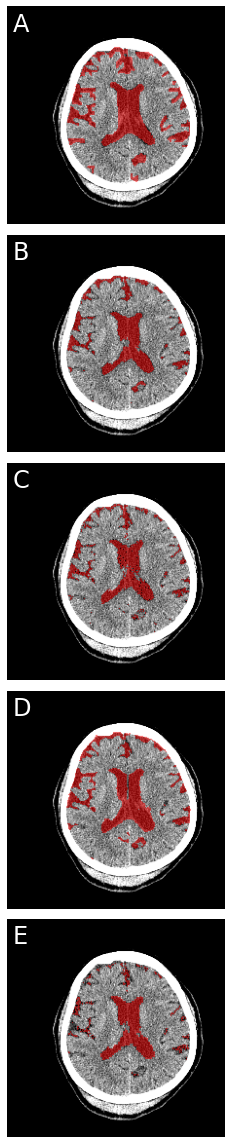

['Non Contrast']
/data4-4tb/kgreathoo/nph_dec_dcm/NPH4/50296397/DICOMOBJ
ImageOrientation: [1.000000, 0.000000, 0.000000, 0.000000, 0.998135, -0.061049]
skipped, no SliceLocation: 0
3D Array: (512, 512, 128)
50296397
SPM12: dice=0.7232 iou=0.5665
CT2D: dice=0.6334 iou=0.4635
CT3D: dice=0.7400 iou=0.5873
WEAK: dice=0.8159 iou=0.6890


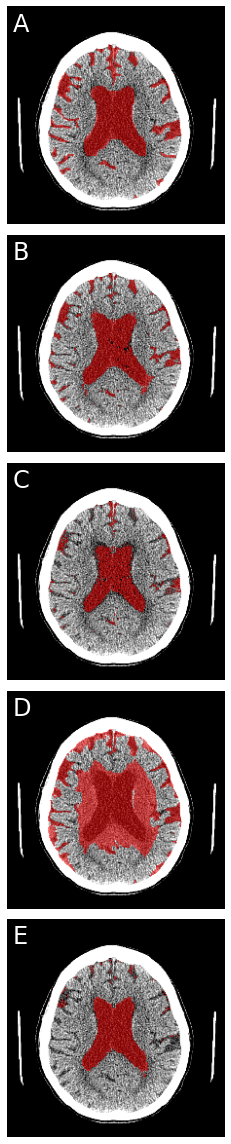

['Non Contrast']
/data4-4tb/kgreathoo/nph_dec_dcm/NPH 2/53701955/DICOMOBJ
ImageOrientation: [1.000000, 0.000000, 0.000000, 0.000000, 0.998135, -0.061049]
skipped, no SliceLocation: 0
3D Array: (512, 512, 112)
53701955
SPM12: dice=0.5909 iou=0.4194
CT2D: dice=0.7937 iou=0.6580
CT3D: dice=0.8380 iou=0.7211
WEAK: dice=0.8839 iou=0.7920


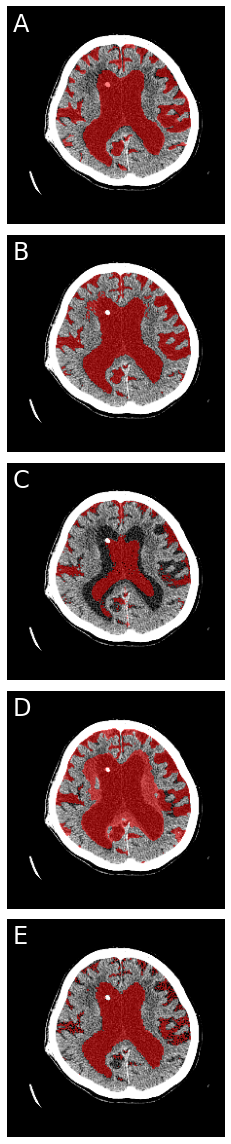

In [8]:
# Calculate DICE and IOU scores
spm12_dices = []
spm12_ious = []
ct2d_dices = []
ct2d_ious = []
ct3d_dices = []
ct3d_ious = []
weak_dices = []
weak_ious = []
for k, v in c_ann_map.items():
    current_p = annotate_df.iloc[k]
    hn = current_p['HN']
    dcm_dir = current_p['dcm']
    weak_mask_fp = current_p['weak']
    spm12_mask_fp = current_p['spm12']
    ct2D_mask_fp = current_p['headCT']
    ct3D_mask_fp = current_p['nph']
    doctor_ann_json = current_p['json']
    with open(doctor_ann_json, 'r') as _f:
        data = json.load(_f)
    doctor_ann = data['data_evaluation']

    # Replace with new SPM12 version
    spm12_mask_fp = spm12_mask_fp.replace(
        'segmentation_mask_v3',
        'segment_mask_confidence1_contour')

#     # Replace with new weak with 1 confident
#     weak_mask_fp = weak_mask_fp.replace(
#     'nii_42_focalloss_200epochs_lr_init=0.001_unet_scaled_(0,40)(0,20)(20,40)_224_allSlice_byTime_fold',
#     '/nii/SPM12floatCodeConfident1_focalloss_200epochs_lr_init=0.001_unet_scaled_(0,40)(0,20)(20,40)_224_allSlice_byTime_fold')

    dcm_files = list(glob.glob(os.path.join(dcm_dir, '*')))
    series = 'non'

    # add dcm data to image variable
    image = read_dcm_series(dcm_files,
                            select_series=series,
                            slice_thickness=1.25)
    x_hu = image
    x = windowing(x_hu, w_min=-5, w_max=60, min_value=0, max_value=1)

    # SPM12
    spm12_mask = nib.load(spm12_mask_fp).get_fdata()
    spm12_mask = spm12_mask.astype('uint8')

    # 2D Unet
    ct2d_mask = nib.load(ct2D_mask_fp).get_fdata()
    ct2d_mask = np.where(ct2d_mask == 0, 0, np.where(
        np.logical_or(ct2d_mask == 2, ct2d_mask == 10), 1, 2))

    # 3D Unet
    ct3d_mask = nib.load(ct3D_mask_fp).get_fdata()
    ct3d_mask = np.where(ct3d_mask == 2, 2, np.where(
        np.logical_or(ct3d_mask == 1, ct3d_mask == 3), 1, 0))  # add non-csf

    # Our
    weak_mask = nib.load(weak_mask_fp).get_fdata()
    weak_mask = weak_mask.astype('uint8')

    spm12_mask = correct_orientation_mask(spm12_mask, mod='spm12')
    ct2d_mask = correct_orientation_mask(ct2d_mask, mod='ct2d')
    ct3d_mask = correct_orientation_mask(ct3d_mask, mod='ct3d')
    weak_mask = correct_orientation_mask(weak_mask, mod='weak')

    for slice_idx in range((spm12_mask.shape[-1])):
        shift_dis_x = 10
        shift_dis_y = 0
        image_shape = (512, 512)
        suffix = ''
        if doctor_ann[f'{slice_idx+1}'].get('additional'):
            print(hn)
            doc_ann_mask = np.zeros(image_shape)
            for k in doctor_ann[f'{slice_idx+1}']['additional'].keys():
                for r in doctor_ann[f'{slice_idx+1}']['additional'][k]['FreehandRoi']['data']:
                    points = r['handles']['points']
                    list_point = []
                    for point in points:
                        list_point.append(
                            [point['x']-shift_dis_x, point['y']-shift_dis_y])
                    polygon = np.array(list_point)
                    mask = polygon2mask(image_shape, polygon)
                    doc_ann_mask += mask
            doc_ann_mask = np.where(doc_ann_mask > 1, 1, doc_ann_mask)
            doc_ann_mask = correct_orientation_mask(doc_ann_mask, mod='doctor')

            # image
            x_gray = x[:, :, slice_idx]*255
            x_gray = cv2.resize(x_gray.astype('uint8'), dsize=(224, 224))
            x_rgb = cv2.cvtColor(x_gray, cv2.COLOR_GRAY2RGB)

            # model masks
            spm12_m = np.where(spm12_mask[:, :, slice_idx] == 1, 1, 0)
            ct2d_m = np.where(ct2d_mask[:, :, slice_idx] == 1, 1, 0)
            ct3d_m = np.where(ct3d_mask[:, :, slice_idx] == 1, 1, 0)
            weak_m = np.where(weak_mask[:, :, slice_idx] == 1, 1, 0)
            spm12_dice = DICE_COE(doc_ann_mask, spm12_m)
            spm12_iou = IOU_score(doc_ann_mask, spm12_m)
            ct2d_dice = DICE_COE(doc_ann_mask, ct2d_m)
            ct2d_iou = IOU_score(doc_ann_mask, ct2d_m)
            ct3d_dice = DICE_COE(doc_ann_mask, ct3d_m)
            ct3d_iou = IOU_score(doc_ann_mask, ct3d_m)
            small_spm12_m = cv2.resize(
                spm12_m.astype('uint8'), dsize=(224, 224))
            small_ct2d_m = cv2.resize(ct2d_m.astype('uint8'), dsize=(224, 224))
            small_ct3d_m = cv2.resize(ct3d_m.astype('uint8'), dsize=(224, 224))
            small_doc_ann_mask = cv2.resize(
                doc_ann_mask.astype('uint8'), dsize=(224, 224))
            weak_dice = DICE_COE(small_doc_ann_mask, weak_m)
            weak_iou = IOU_score(small_doc_ann_mask, weak_m)

            print(f'SPM12: dice={spm12_dice:.4f} iou={spm12_iou:.4f}')
            print(f'CT2D: dice={ct2d_dice:.4f} iou={ct2d_iou:.4f}')
            print(f'CT3D: dice={ct3d_dice:.4f} iou={ct3d_iou:.4f}')
            print(f'WEAK: dice={weak_dice:.4f} iou={weak_iou:.4f}')

            spm12_dices.append(spm12_dice)
            spm12_ious.append(spm12_iou)
            ct2d_dices.append(ct2d_dice)
            ct2d_ious.append(ct2d_iou)
            ct3d_dices.append(ct3d_dice)
            ct3d_ious.append(ct3d_iou)
            weak_dices.append(weak_dice)
            weak_ious.append(weak_iou)

            # CSF overlay
            doctor_img = generate_img_mask(
                x_rgb, small_doc_ann_mask, mod='none', with_noncsf=False)
            spm12_img = generate_img_mask(
                x_rgb, small_spm12_m, mod='none', with_noncsf=False)
            ct2d_img = generate_img_mask(
                x_rgb, small_ct2d_m, mod='none', with_noncsf=False)
            ct3d_img = generate_img_mask(
                x_rgb, small_ct3d_m, mod='none', with_noncsf=False)
            weak_img = generate_img_mask(
                x_rgb, weak_m, mod='none', with_noncsf=False)

            fig, axs = plt.subplots(5, 1, figsize=(8, 16))
            fig.subplots_adjust(wspace=0, hspace=0)
            axs[0].imshow(doctor_img)
            axs[0].text(5, 5, 'A', color='white',
                        fontsize=24, ha='left', va='top')
            axs[0].axis('off')
            axs[1].imshow(weak_img)
            axs[1].text(5, 5, 'B', color='white',
                        fontsize=24, ha='left', va='top')
            axs[1].axis('off')
            axs[2].imshow(spm12_img)
            axs[2].text(5, 5, 'C', color='white',
                        fontsize=24, ha='left', va='top')
            axs[2].axis('off')
            axs[3].imshow(ct2d_img)
            axs[3].text(5, 5, 'D', color='white',
                        fontsize=24, ha='left', va='top')
            axs[3].axis('off')
            axs[4].imshow(ct3d_img)
            axs[4].text(5, 5, 'E', color='white',
                        fontsize=24, ha='left', va='top')
            axs[4].axis('off')
            plt.tight_layout()
            plt.show()
            plt.close('all')


# Visualize features

weak_mask
53427016
[0. 1. 2.]
(128, 224, 224)
[0 1 2]
38145861
[0. 1. 2.]
(133, 224, 224)
[0 1 2]


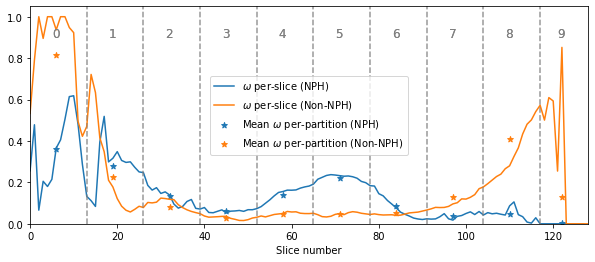

ct2d_mask
53427016
[0. 1. 2.]
(128, 224, 224)
[0 1 2]
38145861
[0. 1. 2.]
(133, 224, 224)
[0 1 2]


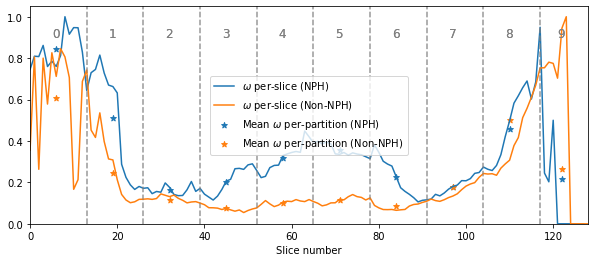

spm12_mask
53427016
[0. 1. 2.]
(128, 224, 224)
[0 1 2]
38145861
[0. 1. 2.]
(133, 224, 224)
[0 1 2]


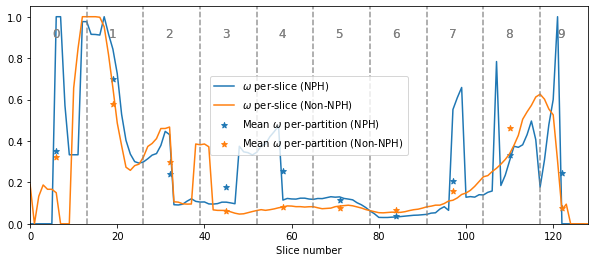

ct3d_mask
53427016
[0. 1. 2.]
(128, 224, 224)
[0 1 2]
38145861
[0. 1. 2.]
(133, 224, 224)
[0 1 2]


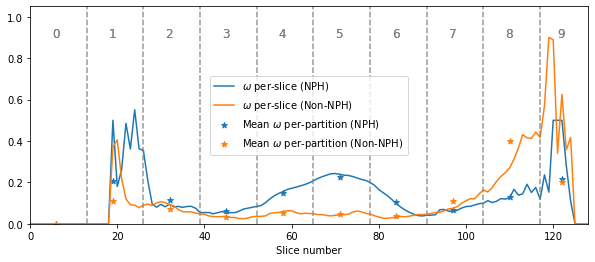

In [9]:
list_HNs = [38145861, 53427016]
counts = 0
mid_idxs = []
for mod_name in ['weak_mask', 'ct2d_mask', 'spm12_mask', 'ct3d_mask']:
    # Calculate features
    fig, ax = plt.subplots(figsize=(10, 4))
    HN_dirs = list(glob.glob(f'/data2-2tb/kgreathoo/_akara_temp_test/*'))
    print(mod_name)
    for HN_dir in HN_dirs:
        HN = int(os.path.basename(HN_dir))

        if not HN in list_HNs:
            continue

        print(HN)

        mask_fp = os.path.join(HN_dir, f'{mod_name}.nii')
        masks = nib.load(mask_fp).get_fdata()
        print(np.unique(masks))
        masks = masks.astype('uint8')
        masks = np.swapaxes(masks, 0, 2)
        print(masks.shape)
        print(np.unique(masks))

        CSF_C = 1
        BRAIN_C = 2
        n_slices, _, _ = masks.shape

        # Whole-brain
        n_csfs = np.count_nonzero(masks == CSF_C)
        n_brains = np.count_nonzero(masks == BRAIN_C)
        n_all = np.prod(masks.shape)
        whole_csf_ratio_img = n_csfs / n_all
        whole_csf_ratio = n_csfs / (n_csfs + n_brains)
        whole_csf_brain = n_csfs / n_brains

        # Per-slice
        slice_csf_ratio_img = np.zeros(n_slices, dtype='float32')
        slice_csf_ratio = np.zeros(n_slices, dtype='float32')
        slice_csf_brain = np.zeros(n_slices, dtype='float32')
        for s in range(n_slices):
            n_csfs = np.count_nonzero(masks[s] == CSF_C)
            n_brains = np.count_nonzero(masks[s] == BRAIN_C)
            n_all = np.prod(masks[s].shape)

            slice_csf_ratio_img[s] = n_csfs / n_all
            n_totals = n_csfs + n_brains
            if n_totals == 0:
                slice_csf_ratio[s] = 0
            else:
                slice_csf_ratio[s] = n_csfs / n_totals
            if n_csfs == 0 or n_brains == 0:
                slice_csf_brain[s] = 0  # np.nan
            else:
                slice_csf_brain[s] = n_csfs / n_brains

        # Partition-brain
        n_parts = 10
        part_csf_ratio_img = np.zeros(n_parts, dtype='float32')
        part_brain_ratio_img = np.zeros(n_parts, dtype='float32')
        part_csf_ratio = np.zeros(n_parts, dtype='float32')
        part_csf_brain = np.zeros(n_parts, dtype='float32')
        part_slice_csf_ratio = np.zeros((n_parts, 4), dtype='float32')
        part_slice_csf_brain = np.zeros((n_parts, 4), dtype='float32')
        part_idxs = np.array_split(np.arange(n_slices), 10)
        for p, idxs in enumerate(part_idxs):
            n_csfs = np.count_nonzero(masks[idxs] == CSF_C)
            n_brains = np.count_nonzero(masks[idxs] == BRAIN_C)
            n_all = np.prod(masks[idxs].shape)

            part_brain_ratio_img[p] = n_brains / n_all
            part_csf_ratio_img[p] = n_csfs / n_all
            n_totals = n_csfs + n_brains
            if n_totals == 0:
                part_csf_ratio[p] = 0
            else:
                part_csf_ratio[p] = n_csfs / n_totals
            if n_csfs == 0 or n_brains == 0:
                part_csf_brain[p] = 0  # np.nan
            else:
                part_csf_brain[p] = n_csfs / n_brains

            part_slice_csf_ratio[p, 0] = np.min(slice_csf_ratio[idxs])
            part_slice_csf_ratio[p, 1] = np.max(slice_csf_ratio[idxs])
            part_slice_csf_ratio[p, 2] = np.mean(slice_csf_ratio[idxs])
            part_slice_csf_ratio[p, 3] = np.std(slice_csf_ratio[idxs])

            part_slice_csf_brain[p, 0] = np.min(slice_csf_brain[idxs])
            part_slice_csf_brain[p, 1] = np.max(slice_csf_brain[idxs])
            part_slice_csf_brain[p, 2] = np.mean(slice_csf_brain[idxs])
            part_slice_csf_brain[p, 3] = np.std(slice_csf_brain[idxs])

            if counts == 0:
                mid_idxs.append(idxs[len(idxs)//2])

        c = list_HNs.index(HN)
        if c == 1:
            cname = 'NPH'
        else:
            cname = 'Non-NPH'

        ax.plot(slice_csf_ratio, label=f"$\omega$ per-slice ({cname})")
        ax.scatter(mid_idxs, part_slice_csf_ratio[:, 2], marker='*',
                   label=f'Mean $\omega$ per-partition ({cname})')
        ax.set_xlabel('Slice number')

        for _xi, _x in enumerate(mid_idxs):
            ax.text(_x-1, 0.9, f'{_xi}', color='grey', size=12)

        slice_per_partition = round(n_slices / 10)
        for _x in np.arange(1, 10) * slice_per_partition:
            ax.axvline(x=_x, color='grey', ls='--', alpha=0.5)
        counts += 1
    plt.xlim([0, 128])
    plt.ylim([0, 1.05])
    plt.legend(loc='center')
    plt.show()
    plt.close('all')


In [10]:
print(f'SPM12: dice={np.mean(spm12_dices):.3f} ({np.std(spm12_dices):.3f}) iou={np.mean(spm12_ious):.3f} ({np.std(spm12_ious):.3f})')
print(f'CT2D: dice={np.mean(ct2d_dices):.3f} ({np.std(ct2d_dices):.3f}) iou={np.mean(ct2d_ious):.3f} ({np.std(ct2d_ious):.3f})')
print(f'CT3D: dice={np.mean(ct3d_dices):.3f} ({np.std(ct3d_dices):.3f}) iou={np.mean(ct3d_ious):.3f} ({np.std(ct3d_ious):.3f})')
print(f'WEAK: dice={np.mean(weak_dices):.3f} ({np.std(weak_dices):.3f}) iou={np.mean(weak_ious):.3f} ({np.std(weak_ious):.3f})')


SPM12: dice=0.657 (0.083) iou=0.494 (0.089)
CT2D: dice=0.746 (0.061) iou=0.598 (0.075)
CT3D: dice=0.659 (0.144) iou=0.508 (0.155)
WEAK: dice=0.747 (0.095) iou=0.605 (0.122)
